In [1]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 
from typing import Any, Optional, List

import qubx
%qubxd dev 

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.core.strategy import IPositionGathering, IStrategy, PositionsTracker, StrategyContext, TriggerEvent
from qubx.pandaz.utils import *

# - - - - - - - - - - - - - - - - - - - - - - - -
from qubx.data.readers import CsvStorageDataReader, MultiQdbConnector, AsTimestampedRecords, AsQuotes, RestoreTicksFromOHLC, AsPandasFrame, RestoreTicksFromOHLC, AsOhlcvSeries
from qubx.core.basics import Deal, Instrument, Order, Position, Signal
from qubx.utils.charting.lookinglass import LookingGlass
from qubx.core.utils import recognize_time, time_to_str

from qubx.backtester.simulator import simulate
from qubx.core.metrics import tearsheet, chart_signals
from qubx.trackers.riskctrl import StopTakePositionTracker
from qubx.trackers.sizers import FixedSizer, FixedRiskSizer, FixedLeverageSizer

 >  [dev] installing cython rebuilding hook

⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. Dev
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


In [4]:
signals = pd.read_csv("../tests/data/generated_signals.csv", index_col="timestamp", parse_dates=True)
print(signals.index[0], signals.index[-1])

exchange = "BINANCE.UM"
symbol = "BTCUSDT"
# reader = CsvStorageDataReader("../tests/data/csv")
# ohlc = reader.read("BTCUSDT_ohlcv_M1", start='2023-08-13', stop='2024-04-30', transform=AsOhlcvSeries())
qdb = MultiQdbConnector('xlydian-data')
ohlc = qdb.read(f"{ exchange }:{symbol}", start=signals.index[0], stop='2024-05-01', transform=AsPandasFrame())

2023-08-13 17:23:33.720000 2024-04-30 22:30:00.030000


2024-09-06 15:15:58.659 [ 🐞 ] Connected to QuestDB at xlydian-data:8812


In [2]:
S = pd.DataFrame({'BTCUSDT': {
    pd.Timestamp('2023-08-27 14:14:45.431000'): +1,
    pd.Timestamp('2023-08-27 14:37:42.621000'): +1,
    pd.Timestamp('2023-08-27 16:16:00.451000'): +1,
    pd.Timestamp('2023-08-27 16:49:18.924000'): +1,
    pd.Timestamp('2023-08-27 19:07:23.468000'): +1,
    pd.Timestamp('2023-08-28 12:09:00.892000'): +1,
    pd.Timestamp('2023-08-28 12:14:24.860000'): +1,
    pd.Timestamp('2023-08-28 12:26:43.505000'): +1,
    pd.Timestamp('2023-08-28 23:19:48.408000'): +1,
    pd.Timestamp('2023-08-29 14:02:56.179000'): +1,
    pd.Timestamp('2023-08-29 14:03:58.530000'): +1,
    pd.Timestamp('2023-08-29 14:21:00.859000'): +1,
    pd.Timestamp('2023-08-29 14:25:55.093000'): +1,
    pd.Timestamp('2023-08-29 14:26:48.430000'): +1}})

In [34]:
S = signals['2023-08-27 14:00':'2023-08-29 14:30']
S = signals
rep = simulate(
    { 
     "liq_buy_bounces_c": [ S, StopTakePositionTracker(2.5, 0.5, FixedLeverageSizer(0.1), "client")],
     "liq_buy_bounces_b": [ S, StopTakePositionTracker(2.5, 0.5, FixedLeverageSizer(0.1), "broker")],
     },
    {f"{exchange}:{symbol}" : ohlc}, 
    10000, [exchange + ":" + symbol], dict(type="ohlc", timeframe="1Min"), "1Min -1Sec", "vip9_usdt", 
    S.index[0], S.index[-1] + pd.Timedelta('5Min'), 
    debug='ERROR')

  0%|          | 0/2 [00:00<?, ?it/s]

Simulating:   0%|          | 0/22568786.31 [00:00<?, ?s/s]

Simulating:   0%|          | 0/22568786.31 [00:00<?, ?s/s]

In [ ]:
rep[0].signals_log

In [ ]:
rep[0].executions_log

In [ ]:
rep[1].executions_log

,,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
id,,,,,,,,,,,,,,,
1,/liq_buy_bounces_b,266.777412,0.037359,1.696122,2.758056,1.417003,144.170087,4.108603,3.016796,1.760826,0.801461,17.691443,0.010114,77.132488,525.0
0,/liq_buy_bounces_c,242.165931,0.033897,1.322224,2.392397,1.790850,183.550548,3.188010,2.010998,1.634179,0.766258,20.952525,0.009222,85.558319,530.0


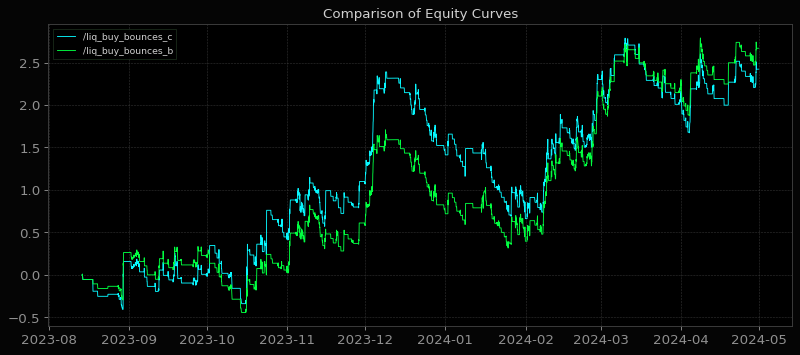

In [35]:
tearsheet(rep)

In [ ]:
chart_signals(rep[0], symbol, ohlc, '1Min',  show_signals=True)